# Spaceship Titanic

In [1]:
import pandas as pd
import numpy as npy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../data/train.csv')

In [3]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [4]:
print(train.shape)
print(train.dropna().shape)

(8693, 14)
(6606, 14)


Text(69.0, 0.5, 'Variables')

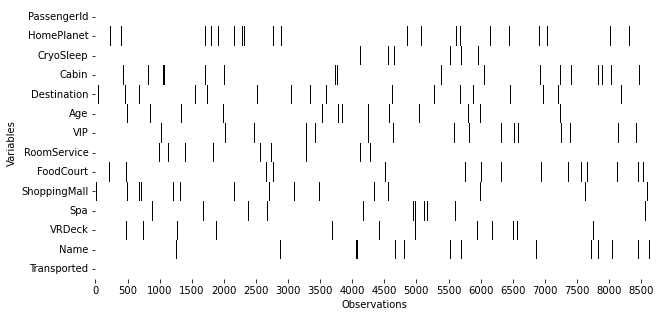

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 5))
sns.heatmap(train.isnull().T, cmap = 'binary', xticklabels = 500, ax = ax, cbar = False)
ax.set_xlabel(r'Observations')
ax.set_ylabel(r'Variables')

In [6]:
data_cabin = \
pd.concat([train.Cabin.str.split('/', expand = True), 
           train.PassengerId, 
           train.Transported], axis = 1)

data_cabin = data_cabin[['PassengerId', 0, 1, 2, 'Transported']].copy()
data_cabin.columns = ['PassengerId', 'deck', 'num', 'side', 'Transported']
data_cabin

,PassengerId,deck,num,side,Transported
0,0001_01,B,0,P,False
1,0002_01,F,0,S,True
2,0003_01,A,0,S,False
3,0003_02,A,0,S,False
4,0004_01,F,1,S,True
...,...,...,...,...,...
8688,9276_01,A,98,P,False
8689,9278_01,G,1499,S,False
8690,9279_01,G,1500,S,True
8691,9280_01,E,608,S,False


In [7]:
data_cabin.deck.value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: deck, dtype: int64

In [8]:
pd.pivot_table(data = data_cabin, 
               index = ['deck'], 
               aggfunc = {'Transported': npy.mean})

,Transported
deck,
A,0.496094
B,0.734275
C,0.680054
D,0.433054
E,0.357306
F,0.439871
G,0.516217
T,0.200000


In [9]:
pd.pivot_table(data = data_cabin, 
               index = ['deck', 'side'], 
               aggfunc = {'Transported': npy.mean}).unstack()

Transported          
side           P         S
deck                      
A       0.435897  0.546763
B       0.674221  0.784038
C       0.580645  0.763547
D       0.403226  0.465217
E       0.342657  0.371365
F       0.410987  0.470501
G       0.448276  0.583788
T       0.250000  0.000000

In [10]:
data_cabin.side.value_counts()

S    4288
P    4206
Name: side, dtype: int64

In [11]:
pd.pivot_table(data = data_cabin, 
               index = ['side'], 
               aggfunc = {'Transported': npy.mean})

,Transported
side,
P,0.451260
S,0.555037


In [12]:
data_train =  \
pd.get_dummies(train, 
               columns = ['HomePlanet', 'Destination'], 
               prefix = ['HP','D'], drop_first = True)\
    .drop(columns = ['Name'])

data_train = \
pd.concat([data_train, train.Cabin.str.split('/', expand = True), ], axis = 1,)

data_train.rename(columns = {0:'deck', 1:'num', 2: 'side'}, inplace = True)
data_train = \
    pd.get_dummies(data_train,
                   columns = ['deck', 'side'], prefix = ['Deck', 'Side'],
                   drop_first = False)
data_train.drop(columns = ['num'], inplace = True)

In [13]:
data_train.RoomService = [0 if x == 0 else 1 for x in data_train.RoomService]
data_train.FoodCourt = [0 if x == 0 else 1 for x in data_train.FoodCourt]
data_train.ShoppingMall = [0 if x == 0 else 1 for x in data_train.ShoppingMall]
data_train.Spa = [0 if x == 0 else 1 for x in data_train.Spa]
data_train.VRDeck = [0 if x == 0 else 1 for x in data_train.VRDeck]

In [14]:
data_train =  \
data_train\
    .set_index('PassengerId')\
    .replace({True:1, False: 0})\
    .drop(columns= ['Cabin'])\
    .dropna()\
    .copy()

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report

In [16]:
X_train = data_train.drop(columns = ['Transported', 'Age'])
y_train = data_train['Transported']

In [17]:
lr = LogisticRegression(max_iter = 5000)
lr.fit(X_train, y_train)
accuracy_score(lr.predict(X_train), y_train)

0.7448199309324124

In [18]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
importance = model.feature_importances_
for i,v in zip(X_train.columns, importance):
    print('%s, Score: %.5f' % (i,v))

CryoSleep, Score: 0.22147
VIP, Score: 0.01436
RoomService, Score: 0.11136
FoodCourt, Score: 0.05719
ShoppingMall, Score: 0.06364
Spa, Score: 0.09972
VRDeck, Score: 0.09722
HP_Europa, Score: 0.04494
HP_Mars, Score: 0.03841
D_PSO J318.5-22, Score: 0.02611
D_TRAPPIST-1e, Score: 0.04890
Deck_A, Score: 0.00564
Deck_B, Score: 0.01477
Deck_C, Score: 0.01549
Deck_D, Score: 0.00948
Deck_E, Score: 0.03067
Deck_F, Score: 0.02771
Deck_G, Score: 0.02826
Deck_T, Score: 0.00033
Side_P, Score: 0.02169
Side_S, Score: 0.02265


In [19]:
importance

array([0.22147285, 0.01436412, 0.11135848, 0.05718561, 0.06363643,
       0.09972086, 0.09722344, 0.04493656, 0.03841284, 0.02610831,
       0.0488963 , 0.00564262, 0.01476765, 0.01549146, 0.00947583,
       0.03067375, 0.02770548, 0.02826351, 0.00032949, 0.02168729,
       0.02264712])

In [20]:
from sklearn.model_selection import train_test_split

In [58]:
salida_ = []

for p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:

    for i in range(50):

        selection = npy.random.choice(a = [False, True], 
                                      size = X_train.shape[1], 
                                      replace = True, 
                                      p = [p,1-p])

        if npy.sum(selection) == 0:
            break
        
        accuracy_ = []

        for rs in range(20):
            X_1, X_2, y_1, y_2 = \
                train_test_split(X_train.loc[:, selection], 
                                 y_train, 
                                 test_size = 0.33, 
                                 random_state = rs)

            lr = LogisticRegression(max_iter = 5000)
            lr.fit(X_1, y_1)
            accuracy_.append(accuracy_score(lr.predict(X_2), y_2))

        salida_.append(list(selection) + [npy.mean(accuracy_)] + [npy.std(accuracy_)])

In [59]:
pd.DataFrame(salida_).sort_values(by = 21, ascending = False)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
101,True,False,True,True,True,True,True,False,True,True,...,True,True,True,True,False,False,False,True,0.746655,0.009440
199,True,False,True,True,False,True,True,True,True,True,...,True,True,True,True,False,True,True,False,0.741555,0.008891
78,True,True,True,True,False,True,True,True,False,True,...,True,True,False,False,False,True,True,True,0.741517,0.008562
192,True,False,True,True,False,True,True,True,True,True,...,True,True,True,True,True,False,True,True,0.741312,0.008263
56,True,False,True,True,False,True,True,True,True,False,...,True,True,True,True,True,True,True,True,0.741200,0.008844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,0.534510,0.005800
402,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,0.534268,0.008281
405,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,0.524383,0.005719
401,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.500411,0.008567


In [61]:
from sklearn.svm import SVC
maximo = 0
salida_ = []

for p in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:

    for i in range(50):

        selection = npy.random.choice(a = [False, True], 
                                      size = X_train.shape[1], 
                                      replace = True, 
                                      p = [p,1-p])

        if npy.sum(selection) == 0:
            break
        
        accuracy_ = []

        for rs in range(20):
            X_1, X_2, y_1, y_2 = \
                train_test_split(X_train.loc[:, selection], 
                                 y_train, 
                                 test_size = 0.33, 
                                 random_state = rs)

            svc = SVC(kernel = 'rbf')
            svc.fit(X_1, y_1)
            accuracy_.append(accuracy_score(svc.predict(X_2), y_2))

        salida_.append(list(selection) + [npy.mean(accuracy_)] + [npy.std(accuracy_)])
        
        if npy.mean(accuracy_) > maximo:
            maximo = npy.mean(accuracy_)
            print(maximo)

0.7443011958146487
0.7500560538116592
0.7509155455904334


KeyboardInterrupt: 

In [59]:
pd.DataFrame(salida_).sort_values(by = 21, ascending = False)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
101,True,False,True,True,True,True,True,False,True,True,...,True,True,True,True,False,False,False,True,0.746655,0.009440
199,True,False,True,True,False,True,True,True,True,True,...,True,True,True,True,False,True,True,False,0.741555,0.008891
78,True,True,True,True,False,True,True,True,False,True,...,True,True,False,False,False,True,True,True,0.741517,0.008562
192,True,False,True,True,False,True,True,True,True,True,...,True,True,True,True,True,False,True,True,0.741312,0.008263
56,True,False,True,True,False,True,True,True,True,False,...,True,True,True,True,True,True,True,True,0.741200,0.008844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,0.534510,0.005800
402,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,0.534268,0.008281
405,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,0.524383,0.005719
401,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.500411,0.008567
